KOOPMAN+MLP (LEARNED OBSERVABLES)

Using device: cpu
Episode 1/1000 | Return: -6.82 | Avg(10): -6.82 | Length: 100
Episode 2/1000 | Return: -100.67 | Avg(10): -53.75 | Length: 99
Episode 3/1000 | Return: -101.37 | Avg(10): -69.62 | Length: 78
Episode 4/1000 | Return: -10.02 | Avg(10): -54.72 | Length: 100
Episode 5/1000 | Return: -6.89 | Avg(10): -45.15 | Length: 100
Episode 6/1000 | Return: -16.58 | Avg(10): -40.39 | Length: 100
Episode 7/1000 | Return: -8.53 | Avg(10): -35.84 | Length: 100
Episode 8/1000 | Return: -12.06 | Avg(10): -32.87 | Length: 100
Episode 9/1000 | Return: -3.47 | Avg(10): -29.60 | Length: 100
Episode 10/1000 | Return: -98.03 | Avg(10): -36.44 | Length: 84
  Losses - World: 76.252, Q1: 77.880, Policy: -0.870, Alpha: 0.197
  Losses - World: 68.928, Q1: 73.207, Policy: -1.018, Alpha: 0.194
Episode 11/1000 | Return: -12.22 | Avg(10): -36.98 | Length: 100
Episode 12/1000 | Return: -106.02 | Avg(10): -37.52 | Length: 80
Episode 13/1000 | Return: -12.85 | Avg(10): -28.67 | Length: 100
Episode 14/1000 | 

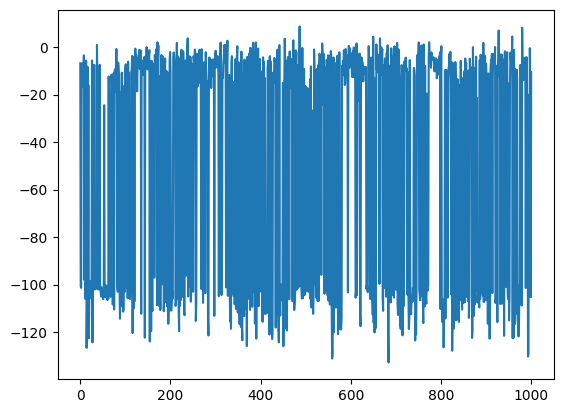

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt



class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.acts_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=64):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs=self.obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            done=self.done_buf[idxs],
        )
        return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in batch.items()}


def mlp(in_dim, out_dim, hidden_sizes=(256, 256), activation=nn.ReLU):
    layers = []
    last_dim = in_dim
    for h in hidden_sizes:
        layers.append(nn.Linear(last_dim, h))
        layers.append(activation())
        last_dim = h
    layers.append(nn.Linear(last_dim, out_dim))
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
   
    def __init__(self, latent_dim, act_dim, act_low, act_high, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = mlp(latent_dim, 2 * act_dim, hidden_sizes)
        self.act_dim = act_dim

        self.register_buffer("act_low", torch.as_tensor(act_low, dtype=torch.float32))
        self.register_buffer("act_high", torch.as_tensor(act_high, dtype=torch.float32))

        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2

    def forward(self, z):
        mean_logstd = self.net(z)
        mean, log_std = torch.chunk(mean_logstd, 2, dim=-1)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = torch.exp(log_std)
        return mean, std

    def sample(self, z):
        mean, std = self(z)
        dist = torch.distributions.Normal(mean, std)
        x_t = dist.rsample()
        y_t = torch.tanh(x_t)

        log_prob = dist.log_prob(x_t).sum(dim=-1, keepdim=True)
        log_prob -= torch.sum(torch.log(1 - y_t.pow(2) + 1e-6), dim=-1, keepdim=True)

        action = (self.act_high + self.act_low) / 2 + (self.act_high - self.act_low) / 2 * y_t
        return action, log_prob

    def deterministic(self, z):
        mean, _ = self(z)
        y_t = torch.tanh(mean)
        action = (self.act_high + self.act_low) / 2 + (self.act_high - self.act_low) / 2 * y_t
        return action


class QNetwork(nn.Module):
    def __init__(self, latent_dim, act_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = mlp(latent_dim + act_dim, 1, hidden_sizes)

    def forward(self, z, a):
        x = torch.cat([z, a], dim=-1)
        return self.net(x)


#### KOOPMAN STUFF ####
class Encoder(nn.Module):
    def __init__(self, obs_dim, latent_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = mlp(obs_dim, latent_dim, hidden_sizes)

    def forward(self, obs):
        return self.net(obs)


class Decoder(nn.Module):
    """Reconstruction decoder for regularization"""
    def __init__(self, latent_dim, obs_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = mlp(latent_dim, obs_dim, hidden_sizes)

    def forward(self, z):
        return self.net(z)


class KoopmanLinear(nn.Module):
  
    def __init__(self, latent_dim, act_dim):
        super().__init__()
        self.K_z = nn.Linear(latent_dim, latent_dim, bias=False)
        self.K_a = nn.Linear(act_dim, latent_dim, bias=True)
        
    def forward(self, z, a):
        return self.K_z(z) + self.K_a(a)
    
    def multi_step(self, z, actions):
        for a in actions:
            z = self.forward(z, a)
        return z


# Reward model in the lifted space
class RewardModel(nn.Module):
    def __init__(self, latent_dim, act_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = mlp(latent_dim + act_dim, 1, hidden_sizes)

    def forward(self, z, a):
        x = torch.cat([z, a], dim=-1)
        return self.net(x)


# =========================
# Koopman + SAC Agent
# =========================

class KoopmanSACAgent:
    def __init__(
        self,
        obs_dim,
        act_dim,
        act_low,
        act_high,
        latent_dim=64,
        gamma=0.99,
        alpha=0.2,
        lr=3e-4,
        device="cpu",
        H=3,
        num_plan_samples=64,
        reconstruction_weight=0.1,
        koopman_weight=1.0,
        reward_weight=1.0,
    ):
        self.device = device
        self.gamma = gamma
        self.H = H
        self.num_plan_samples = num_plan_samples
        self.reconstruction_weight = reconstruction_weight
        self.koopman_weight = koopman_weight
        self.reward_weight = reward_weight

        # Koopman components
        self.encoder = Encoder(obs_dim, latent_dim).to(device)
        self.decoder = Decoder(latent_dim, obs_dim).to(device)
        self.koopman = KoopmanLinear(latent_dim, act_dim).to(device)
        self.reward_model = RewardModel(latent_dim, act_dim).to(device)

        # SAC in latent space
        self.policy = GaussianPolicy(latent_dim, act_dim, act_low, act_high).to(device)
        self.q1 = QNetwork(latent_dim, act_dim).to(device)
        self.q2 = QNetwork(latent_dim, act_dim).to(device)
        self.q1_target = QNetwork(latent_dim, act_dim).to(device)
        self.q2_target = QNetwork(latent_dim, act_dim).to(device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        # Joint optimizer for world model (encoder, decoder, koopman, reward)
        world_model_params = (
            list(self.encoder.parameters()) +
            list(self.decoder.parameters()) +
            list(self.koopman.parameters()) +
            list(self.reward_model.parameters())
        )
        self.opt_world = optim.Adam(world_model_params, lr=lr)
        
        # SAC optimizers
        self.opt_policy = optim.Adam(self.policy.parameters(), lr=lr)
        self.opt_q1 = optim.Adam(self.q1.parameters(), lr=lr)
        self.opt_q2 = optim.Adam(self.q2.parameters(), lr=lr)

        # Entropy temperature
        self.target_entropy = -act_dim
        self.log_alpha = torch.tensor(np.log(alpha), requires_grad=True, device=device)
        self.opt_alpha = optim.Adam([self.log_alpha], lr=lr)

    @property
    def alpha_val(self):
        return self.log_alpha.exp()

    # ---------- Planning API ----------

    def encode(self, obs_np):
        obs_t = torch.as_tensor(obs_np, dtype=torch.float32, device=self.device)
        if obs_t.dim() == 1:
            obs_t = obs_t.unsqueeze(0)
        with torch.no_grad():
            z = self.encoder(obs_t)
        return z

    def plan_action(self, obs_np):
        """
        Improved H-step lookahead planning with:
        - Better action space exploration via adding noise
        - More efficient trajectory evaluation
        """
        with torch.no_grad():
            z0 = self.encode(obs_np)
            z0 = z0.repeat(self.num_plan_samples, 1)

            # Generate action sequences with exploration noise
            act_seqs = []
            for h in range(self.H):
                a_h, _ = self.policy.sample(z0)
                # Add exploration noise to diversify samples
                noise = torch.randn_like(a_h) * 0.1
                a_h = torch.clamp(a_h + noise, 
                                 self.policy.act_low.min(), 
                                 self.policy.act_high.max())
                act_seqs.append(a_h)

            # Roll out trajectories and accumulate returns
            total_returns = torch.zeros(self.num_plan_samples, 1, device=self.device)
            z = z0.clone()

            for h in range(self.H):
                a_h = act_seqs[h]
                r_h = self.reward_model(z, a_h)
                total_returns += (self.gamma ** h) * r_h
                z = self.koopman(z, a_h)

            # Terminal value from SAC
            a_terminal, logp_term = self.policy.sample(z)
            q1_term = self.q1(z, a_terminal)
            q2_term = self.q2(z, a_terminal)
            q_min = torch.min(q1_term, q2_term)
            v_term = q_min - self.alpha_val * logp_term
            total_returns += (self.gamma ** self.H) * v_term

            # Select best trajectory
            best_idx = torch.argmax(total_returns, dim=0).item()
            best_a0 = act_seqs[0][best_idx:best_idx + 1]
            return best_a0.cpu().numpy()[0]

    # ---------- Training Update ----------

    def update(self, batch, tau=0.005):
        obs = batch["obs"].to(self.device)
        acts = batch["acts"].to(self.device)
        rews = batch["rews"].unsqueeze(-1).to(self.device)
        next_obs = batch["next_obs"].to(self.device)
        done = batch["done"].unsqueeze(-1).to(self.device)

        # ---- World Model Update (encoder receives gradients from all losses) ----
        
        # Encode observations
        z = self.encoder(obs)
        z_next_true = self.encoder(next_obs)
        
        # 1. Koopman prediction loss
        z_next_pred = self.koopman(z, acts)
        koopman_loss = F.mse_loss(z_next_pred, z_next_true)
        
        # 2. Reward prediction loss
        r_pred = self.reward_model(z, acts)
        reward_loss = F.mse_loss(r_pred, rews)
        
        # 3. Reconstruction loss (regularization)
        obs_recon = self.decoder(z)
        next_obs_recon = self.decoder(z_next_pred)
        reconstruction_loss = (
            F.mse_loss(obs_recon, obs) + 
            F.mse_loss(next_obs_recon, next_obs)
        ) / 2.0
        
        # Combined world model loss
        world_model_loss = (
            self.koopman_weight * koopman_loss +
            self.reward_weight * reward_loss +
            self.reconstruction_weight * reconstruction_loss
        )
        
        self.opt_world.zero_grad()
        world_model_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.encoder.parameters()) + 
            list(self.decoder.parameters()) + 
            list(self.koopman.parameters()) + 
            list(self.reward_model.parameters()), 
            max_norm=10.0
        )
        self.opt_world.step()

        # ---- SAC Updates (detach to prevent backprop through world model) ----
        with torch.no_grad():
            z_detach = self.encoder(obs)
            z_next_detach = self.encoder(next_obs)

        # SAC critic update
        with torch.no_grad():
            a_next, logp_next = self.policy.sample(z_next_detach)
            q1_next = self.q1_target(z_next_detach, a_next)
            q2_next = self.q2_target(z_next_detach, a_next)
            q_next_min = torch.min(q1_next, q2_next)
            target_q = rews + (1.0 - done) * self.gamma * (q_next_min - self.alpha_val * logp_next)

        q1_pred = self.q1(z_detach, acts)
        q2_pred = self.q2(z_detach, acts)
        q1_loss = F.mse_loss(q1_pred, target_q)
        q2_loss = F.mse_loss(q2_pred, target_q)

        self.opt_q1.zero_grad()
        q1_loss.backward()
        self.opt_q1.step()

        self.opt_q2.zero_grad()
        q2_loss.backward()
        self.opt_q2.step()

        # SAC policy update
        a_pi, logp_pi = self.policy.sample(z_detach)
        q1_pi = self.q1(z_detach, a_pi)
        q2_pi = self.q2(z_detach, a_pi)
        q_pi_min = torch.min(q1_pi, q2_pi)

        policy_loss = (self.alpha_val * logp_pi - q_pi_min).mean()

        self.opt_policy.zero_grad()
        policy_loss.backward()
        self.opt_policy.step()

        # Alpha update
        alpha_loss = -(self.log_alpha * (logp_pi + self.target_entropy).detach()).mean()
        self.opt_alpha.zero_grad()
        alpha_loss.backward()
        self.opt_alpha.step()

        # Soft update targets
        with torch.no_grad():
            for p, p_targ in zip(self.q1.parameters(), self.q1_target.parameters()):
                p_targ.data.copy_(p_targ.data * (1.0 - tau) + p.data * tau)
            for p, p_targ in zip(self.q2.parameters(), self.q2_target.parameters()):
                p_targ.data.copy_(p_targ.data * (1.0 - tau) + p.data * tau)

        return {
            "koopman_loss": koopman_loss.item(),
            "reward_loss": reward_loss.item(),
            "reconstruction_loss": reconstruction_loss.item(),
            "world_model_loss": world_model_loss.item(),
            "q1_loss": q1_loss.item(),
            "q2_loss": q2_loss.item(),
            "policy_loss": policy_loss.item(),
            "alpha": self.alpha_val.item(),
        }


# =========================
# Training Loop
# =========================

def train_koopman_sac(
    env_name="Pendulum-v1",
    num_episodes=200,
    max_steps_per_episode=200,
    replay_size=100000,
    batch_size=128,
    start_random_steps=1000,
    update_after=1000,
    update_every=50,
    H=3,
    num_plan_samples=64,
    latent_dim=64,
    seed=0,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    env = gym.make(env_name)
    assert isinstance(env.action_space, gym.spaces.Box), "Environment must have continuous actions."

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_low = env.action_space.low
    act_high = env.action_space.high

    # Seeding
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    env.reset(seed=seed)

    replay_buffer = ReplayBuffer(obs_dim, act_dim, replay_size)
    agent = KoopmanSACAgent(
        obs_dim=obs_dim,
        act_dim=act_dim,
        act_low=act_low,
        act_high=act_high,
        latent_dim=latent_dim,
        H=H,
        num_plan_samples=num_plan_samples,
        device=device,
    )

    total_steps = 0
    returns = []
    recent_returns = deque(maxlen=10)

    for ep in range(num_episodes):
        obs, info = env.reset()
        ep_ret = 0.0
        ep_len = 0

        for t in range(max_steps_per_episode):
            total_steps += 1
            ep_len += 1

            # Action selection
            if total_steps < start_random_steps:
                act = env.action_space.sample()
            else:
                act = agent.plan_action(obs)
            act = np.asarray(act, dtype=np.float32)

            next_obs, rew, terminated, truncated, info = env.step(act)
            done = terminated or truncated
            ep_ret += rew

            replay_buffer.store(obs, act, rew, next_obs, float(done))
            obs = next_obs

            # Training updates
            if total_steps >= update_after and total_steps % update_every == 0:
                for _ in range(update_every):
                    batch = replay_buffer.sample_batch(batch_size)
                    loss_dict = agent.update(batch)
                
                # Print loss every 10 episodes
                if ep % 10 == 0:
                    print(f"  Losses - World: {loss_dict['world_model_loss']:.3f}, "
                          f"Q1: {loss_dict['q1_loss']:.3f}, "
                          f"Policy: {loss_dict['policy_loss']:.3f}, "
                          f"Alpha: {loss_dict['alpha']:.3f}")

            if done:
                break

        returns.append(ep_ret)
        recent_returns.append(ep_ret)
        avg_return = np.mean(recent_returns)
        
        print(f"Episode {ep+1}/{num_episodes} | Return: {ep_ret:.2f} | "
              f"Avg(10): {avg_return:.2f} | Length: {ep_len}")

    env.close()
    return returns, agent


if __name__ == "__main__":
    # ENV_NAME = "Pendulum-v1" 
    ENV_NAME = "BipedalWalker-v3"  # Uncomment for harder task

    returns, agent = train_koopman_sac(
        env_name=ENV_NAME,
        num_episodes=1000,
        max_steps_per_episode=100 if "Pendulum" in ENV_NAME else 100,
        H=3,
        num_plan_samples=32,
        latent_dim=64,
        seed=42,
    )
    print("\nTraining finished!")
    print(f"Final average return (last 10 eps): {np.mean(returns[-10:]):.2f}")
    plt.plot(np.linspace(0, len(returns), len(returns)), returns)

    

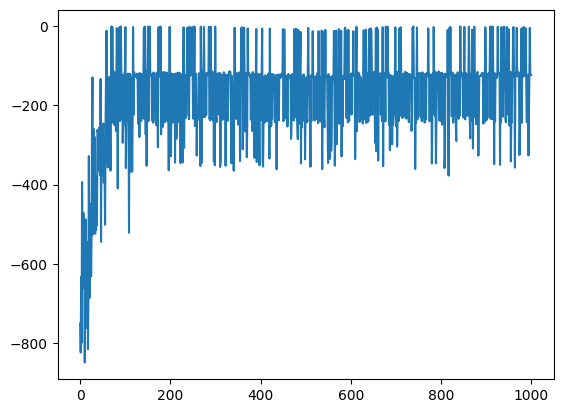

In [39]:
plt.plot(np.linspace(0, len(returns), len(returns)), returns)

STRAIGHT SAC

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym


# ============================================================
# Replay Buffer
# ============================================================
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf      = np.zeros((size, obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.acts_buf     = np.zeros((size, act_dim), dtype=np.float32)
        self.rews_buf     = np.zeros(size, dtype=np.float32)
        self.done_buf     = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]      = obs
        self.acts_buf[self.ptr]     = act
        self.rews_buf[self.ptr]     = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr]     = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs      = self.obs_buf[idxs],
            acts     = self.acts_buf[idxs],
            rews     = self.rews_buf[idxs],
            next_obs = self.next_obs_buf[idxs],
            done     = self.done_buf[idxs],
        )
        return batch


# ============================================================
# Neural Network: simple MLP builder
# ============================================================
def mlp(sizes, activation=nn.ReLU, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


# ============================================================
# Gaussian Policy (Actor)
# ============================================================
class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, action_limit):
        super().__init__()
        self.net = mlp([obs_dim] + hidden_sizes,
                       activation=nn.ReLU,
                       output_activation=nn.ReLU)
        
        self.mean_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)

        self.action_limit = action_limit
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX =  2

    def forward(self, obs):
        x = self.net(obs)
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mean, log_std.exp()

    def sample(self, obs):
        mean, std = self.forward(obs)
        normal = Normal(mean, std)

        z = normal.rsample()               # reparameterization
        a = torch.tanh(z)
        action = self.action_limit * a

        # log π(a|s)
        log_prob = normal.log_prob(z) - torch.log(1 - a.pow(2) + 1e-7)
        log_prob = log_prob.sum(axis=-1, keepdim=True)

        mean_action = self.action_limit * torch.tanh(mean)
        return action, log_prob, mean_action


# ============================================================
# Q-value Networks (Critics)
# ============================================================
class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + hidden_sizes + [1],
                     activation=nn.ReLU,
                     output_activation=nn.Identity)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.q(x)


# ============================================================
# Soft Actor-Critic Agent
# ============================================================
class SACAgent:
    def __init__(self, obs_dim, act_dim, action_limit,
                 gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=3e-4, critic_lr=3e-4,
                 hidden_sizes=[256, 256]):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_limit = action_limit
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha   # entropy coefficient

        # Actor
        self.actor = GaussianPolicy(obs_dim, act_dim, hidden_sizes, action_limit).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critics
        self.q1 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q1_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=critic_lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=critic_lr)

    # Select greedy or exploratory
    def select_action(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if deterministic:
                _, _, action = self.actor.sample(obs)
            else:
                action, _, _ = self.actor.sample(obs)
        return action.cpu().numpy()[0]

    # Gradient update
    def update(self, batch):
        obs = torch.as_tensor(batch['obs'], dtype=torch.float32, device=self.device)
        acts = torch.as_tensor(batch['acts'], dtype=torch.float32, device=self.device)
        rews = torch.as_tensor(batch['rews'], dtype=torch.float32, device=self.device).unsqueeze(-1)
        next_obs = torch.as_tensor(batch['next_obs'], dtype=torch.float32, device=self.device)
        done = torch.as_tensor(batch['done'], dtype=torch.float32, device=self.device).unsqueeze(-1)

        # -------- Target Q -------- #
        with torch.no_grad():
            next_action, next_log_prob, _ = self.actor.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_target = torch.min(q1_next, q2_next) - self.alpha * next_log_prob
            target_value = rews + self.gamma * (1 - done) * q_target

        # -------- Update Q1 -------- #
        q1 = self.q1(obs, acts)
        q1_loss = F.mse_loss(q1, target_value)
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        # -------- Update Q2 -------- #
        q2 = self.q2(obs, acts)
        q2_loss = F.mse_loss(q2, target_value)
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        # -------- Update Actor -------- #
        new_actions, log_prob, _ = self.actor.sample(obs)
        q1_new = self.q1(obs, new_actions)
        q2_new = self.q2(obs, new_actions)
        q_new = torch.min(q1_new, q2_new)

        actor_loss = (self.alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # -------- Soft update targets -------- #
        with torch.no_grad():
            for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)
            for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)


# ============================================================
# TRAIN SAC
# ============================================================
def train_sac():
    env = gym.make("Pendulum-v1")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    action_limit = float(env.action_space.high[0])

    agent = SACAgent(obs_dim, act_dim, action_limit)

    replay_buffer = ReplayBuffer(obs_dim, act_dim, size=200000)

    max_steps = 20000
    start_steps = 1000
    update_after = 1000
    update_every = 50
    batch_size = 256
    max_ep_len = 200

    total_steps = 0
    ep = 0

    all_steps = 0
    all_ep_returns = []

    while total_steps < max_steps:
        state, _ = env.reset()
        ep += 1
        ep_return = 0
        ep_len = 0

        for t in range(max_ep_len):
            if total_steps < start_steps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state, deterministic=False)

            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.store(state, action, reward, next_state, float(done))
            state = next_state

            ep_return += reward
            ep_len += 1
            total_steps += 1

            # Learn
            if total_steps >= update_after and total_steps % update_every == 0:
                for _ in range(update_every):
                    batch = replay_buffer.sample_batch(batch_size)
                    agent.update(batch)

            if done or total_steps >= max_steps:
                print(f"Episode {ep} | Return: {ep_return:.2f} | Length: {ep_len}")
                all_steps += ep_len
                all_ep_returns.append((all_steps, ep_return))
                break

    env.close()
    print("Finished training SAC.")

    # Save trained policy
    torch.save(agent.actor.state_dict(), "actor_final.pt")
    torch.save(agent.q1.state_dict(),   "q1_final.pt")
    torch.save(agent.q2.state_dict(),   "q2_final.pt")
    print("Saved SAC weights!")

    return agent, all_steps, all_ep_returns


# ============================================================
# RUN TRAINED AGENT WITH GUI
# ============================================================
def run_agent(agent, env_name="Pendulum-v1", episodes=3, max_steps=200, deterministic=True):
    env = gym.make(env_name, render_mode="human")

    for ep in range(episodes):
        state, _ = env.reset()
        ep_return = 0

        print(f"\n=== Running Episode {ep+1}/{episodes} ===")

        for step in range(max_steps):
            action = agent.select_action(state, deterministic=True)
            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state

            ep_return += reward
            if terminated or truncated:
                break

        print(f"Episode {ep+1} Return = {ep_return:.2f}")

    env.close()
    print("Training complete.")

    torch.save(agent.actor.state_dict(), "actor_final_SAC.pt")
    torch.save(agent.q1.state_dict(), "q1_final_SAC.pt")
    torch.save(agent.q2.state_dict(), "q2_final_SAC.pt")
    print("Saved trained SAC weights!")


# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    # trained_agent_SAC, all_steps2, all_ep_returns2 = train_sac()
    run_agent(trained_agent_SAC, env_name="Pendulum-v1", episodes=3)



=== Running Episode 1/3 ===
Episode 1 Return = -122.49

=== Running Episode 2/3 ===
Episode 2 Return = -117.28

=== Running Episode 3/3 ===
Episode 3 Return = -124.70
Training complete.
Saved trained SAC weights!


KOOPMAN + PLANNING + RL

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym


class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf      = np.zeros((size, obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.acts_buf     = np.zeros((size, act_dim), dtype=np.float32)
        self.rews_buf     = np.zeros(size, dtype=np.float32)
        self.done_buf     = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]      = obs
        self.acts_buf[self.ptr]     = act
        self.rews_buf[self.ptr]     = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr]     = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs      = self.obs_buf[idxs],
            acts     = self.acts_buf[idxs],
            rews     = self.rews_buf[idxs],
            next_obs = self.next_obs_buf[idxs],
            done     = self.done_buf[idxs],
        )
        return batch


def mlp(sizes, activation=nn.ReLU, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, action_limit):
        super().__init__()
        self.net = mlp([obs_dim] + hidden_sizes,
                       activation=nn.ReLU,
                       output_activation=nn.ReLU)
        
        self.mean_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)

        self.action_limit = action_limit
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX =  2

    def forward(self, obs):
        x = self.net(obs)
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mean, log_std.exp()

    def sample(self, obs):
        mean, std = self.forward(obs)
        normal = Normal(mean, std)

        z = normal.rsample()               # reparameterization
        a = torch.tanh(z)
        action = self.action_limit * a

        # log π(a|s)
        log_prob = normal.log_prob(z) - torch.log(1 - a.pow(2) + 1e-7)
        log_prob = log_prob.sum(axis=-1, keepdim=True)

        mean_action = self.action_limit * torch.tanh(mean)
        return action, log_prob, mean_action


class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + hidden_sizes + [1],
                     activation=nn.ReLU,
                     output_activation=nn.Identity)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.q(x)


class DynamicsModel(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes=[256, 256]):
        super().__init__()
        self.net = mlp([obs_dim + act_dim] + hidden_sizes + [obs_dim + 1],
                       activation=nn.ReLU,
                       output_activation=nn.Identity)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        out = self.net(x)
        delta = out[..., :-1]
        reward = out[..., -1:]
        return delta, reward


class SACAgent:
    def __init__(self, obs_dim, act_dim, action_limit,
                 gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=3e-4, critic_lr=3e-4,
                 hidden_sizes=[256, 256]):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_limit = action_limit
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha   # entropy coefficient

        # Actor
        self.actor = GaussianPolicy(obs_dim, act_dim, hidden_sizes, action_limit).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critics
        self.q1 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q1_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=critic_lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=critic_lr)

    def select_action(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if deterministic:
                _, _, action = self.actor.sample(obs)
            else:
                action, _, _ = self.actor.sample(obs)
        return action.cpu().numpy()[0]

    def update(self, batch):
        obs = torch.as_tensor(batch['obs'], dtype=torch.float32, device=self.device)
        acts = torch.as_tensor(batch['acts'], dtype=torch.float32, device=self.device)
        rews = torch.as_tensor(batch['rews'], dtype=torch.float32, device=self.device).unsqueeze(-1)
        next_obs = torch.as_tensor(batch['next_obs'], dtype=torch.float32, device=self.device)
        done = torch.as_tensor(batch['done'], dtype=torch.float32, device=self.device).unsqueeze(-1)

        # -------- Target Q -------- #
        with torch.no_grad():
            next_action, next_log_prob, _ = self.actor.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_target = torch.min(q1_next, q2_next) - self.alpha * next_log_prob
            target_value = rews + self.gamma * (1 - done) * q_target

        # -------- Update Q1 -------- #
        q1 = self.q1(obs, acts)
        q1_loss = F.mse_loss(q1, target_value)
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        # -------- Update Q2 -------- #
        q2 = self.q2(obs, acts)
        q2_loss = F.mse_loss(q2, target_value)
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        # -------- Update Actor -------- #
        new_actions, log_prob, _ = self.actor.sample(obs)
        q1_new = self.q1(obs, new_actions)
        q2_new = self.q2(obs, new_actions)
        q_new = torch.min(q1_new, q2_new)

        actor_loss = (self.alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # -------- Soft update targets -------- #
        with torch.no_grad():
            for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)
            for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)


def train_dynamics_ensemble(models, buffer, device,
                            batch_size=256, updates=200):
    if buffer.size < batch_size:
        return

    for _ in range(updates):
        batch = buffer.sample_batch(batch_size)
        obs = torch.as_tensor(batch['obs'], dtype=torch.float32, device=device)
        acts = torch.as_tensor(batch['acts'], dtype=torch.float32, device=device)
        next_obs = torch.as_tensor(batch['next_obs'], dtype=torch.float32, device=device)
        rews = torch.as_tensor(batch['rews'], dtype=torch.float32, device=device).unsqueeze(-1)

        for model, opt in models:
            delta_pred, rew_pred = model(obs, acts)
            delta_true = next_obs - obs

            loss_delta = F.mse_loss(delta_pred, delta_true)
            loss_rew   = F.mse_loss(rew_pred, rews)
            loss = loss_delta + loss_rew

            opt.zero_grad()
            loss.backward()
            opt.step()


def plan_action_with_model(state, agent, models, action_limit,
                           H=3, N=64, iters=3, gamma=0.99, beta=0.7):
    """
    state: np array (obs_dim,)
    agent: SACAgent
    models: list of (DynamicsModel, optimizer)
    Returns: np array action (act_dim,)
    """

    device = agent.device
    obs_dim = agent.obs_dim
    act_dim = agent.act_dim

    if len(models) == 0:
        # Fallback to actor if no models
        return agent.select_action(state, deterministic=False)

    with torch.no_grad():
        s0 = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # Get actor's mean action as prior
        mean_action, _, _ = agent.actor.sample(s0)   # (1, act_dim)
        mean_action = mean_action.squeeze(0)         # (act_dim,)

        # Init sequence mean & std (H, act_dim)
        seq_mean = mean_action.unsqueeze(0).repeat(H, 1)  # same mean for all steps
        seq_std  = (0.5 * action_limit) * torch.ones_like(seq_mean)

        for _ in range(iters):
            # Sample N action sequences: (N, H, act_dim)
            eps = torch.randn(N, H, act_dim, device=device)
            actions = seq_mean.unsqueeze(0) + seq_std.unsqueeze(0) * eps
            actions = torch.clamp(actions, -action_limit, action_limit)

            # Rollout in model
            s = s0.unsqueeze(0).repeat(N, 1, 1)  # (N,1,obs_dim)
            s = s[:, 0, :]                       # (N, obs_dim)

            returns = torch.zeros(N, 1, device=device)

            for t in range(H):
                a_t = actions[:, t, :]
                # Pick a random model per sequence for diversity
                idxs = torch.randint(0, len(models), (N,), device=device)
                delta_list = []
                rew_list = []
                for m_i in range(len(models)):
                    mask = (idxs == m_i)
                    if mask.sum() == 0:
                        continue
                    model = models[m_i][0]
                    delta_pred, rew_pred = model(s[mask], a_t[mask])
                    # store back
                    delta_list.append((mask, delta_pred, rew_pred))
                # aggregate
                new_s = s.clone()
                rew_t = torch.zeros_like(returns)
                for mask, delta_pred, rew_pred in delta_list:
                    new_s[mask] = s[mask] + delta_pred
                    rew_t[mask] = rew_pred
                s = new_s
                returns += (gamma**t) * rew_t

            # Add bootstrap value from critic at s_H
            a_H, _, _ = agent.actor.sample(s)
            q1_H = agent.q1(s, a_H)
            q2_H = agent.q2(s, a_H)
            q_H = torch.min(q1_H, q2_H)
            returns += (gamma**H) * q_H

            # Softmax weights over sequences
            scores = returns.squeeze(1)
            scores = scores - scores.max()     # numerical stability
            weights = torch.softmax(scores, dim=0)  # (N,)

            # Update mean and std per time-step (CEM-like)
            w = weights.view(N, 1, 1)
            seq_mean = (w * actions).sum(dim=0)           # (H, act_dim)
            diff = actions - seq_mean.unsqueeze(0)
            seq_std = torch.sqrt((w * diff**2).sum(dim=0) + 1e-6)

        # Use mean at time 0
        a0 = seq_mean[0]
        return a0.cpu().numpy()


def train_sac_with_planning():
    env = gym.make("Pendulum-v1")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    action_limit = float(env.action_space.high[0])

    agent = SACAgent(obs_dim, act_dim, action_limit)
    replay_buffer = ReplayBuffer(obs_dim, act_dim, size=200000)

    # Dynamics ensemble
    ensemble_size = 5
    models = []
    for _ in range(ensemble_size):
        m = DynamicsModel(obs_dim, act_dim).to(agent.device)
        opt = optim.Adam(m.parameters(), lr=1e-3)
        models.append((m, opt))

    max_steps = 20000
    start_steps = 1000          
    update_after = 1000
    update_every = 50
    batch_size = 256
    max_ep_len = 200

    model_train_every = 1000
    model_updates = 200

    total_steps = 0
    ep = 0

    all_steps = 0
    all_ep_returns = []

    while total_steps < max_steps:
        state, _ = env.reset()
        ep += 1
        ep_return = 0
        ep_len = 0

        for t in range(max_ep_len):
            if total_steps < start_steps:
                action = env.action_space.sample()
            else:
                # Use planner instead of raw actor
                action = plan_action_with_model(
                    state, agent, models, action_limit,
                    H=3, N=64, iters=3, gamma=agent.gamma, beta=0.7
                )

            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.store(state, action, reward, next_state, float(done))
            state = next_state

            ep_return += reward
            ep_len += 1
            total_steps += 1

            # SAC updates
            if total_steps >= update_after and total_steps % update_every == 0:
                for _ in range(update_every):
                    batch = replay_buffer.sample_batch(batch_size)
                    agent.update(batch)

            # Train dynamics ensemble
            if total_steps >= update_after and total_steps % model_train_every == 0:
                print(f"[Step {total_steps}] Training dynamics models...")
                train_dynamics_ensemble(models, replay_buffer, agent.device,
                                        batch_size=batch_size, updates=model_updates)
                print("[Step", total_steps, "] Dynamics training done.")

            if done or total_steps >= max_steps:
                print(f"Episode {ep} | Return: {ep_return:.2f} | Length: {ep_len}")
                all_steps += ep_len
                all_ep_returns.append((all_steps, ep_return))
                break

    env.close()
    print("Finished training SAC + planner.")

    # Save trained policy
    torch.save(agent.actor.state_dict(), "actor_final_plan.pt")
    torch.save(agent.q1.state_dict(),   "q1_final_plan.pt")
    torch.save(agent.q2.state_dict(),   "q2_final_plan.pt")
    print("Saved SAC weights!")

    return agent, all_steps, all_ep_returns


def run_agent(agent, env_name="Pendulum-v1", episodes=3, max_steps=200, deterministic=True):
    env = gym.make(env_name, render_mode="human")

    for ep in range(episodes):
        state, _ = env.reset()
        ep_return = 0

        print(f"\n=== Running Episode {ep+1}/{episodes} ===")

        for step in range(max_steps):
            action = agent.select_action(state, deterministic=deterministic)
            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state

            ep_return += reward
            if terminated or truncated:
                break

        print(f"Episode {ep+1} Return = {ep_return:.2f}")

    env.close()
    print("\nDone displaying agent!")


if __name__ == "__main__":
    trained_agent_SAC_w_planning, all_steps3, all_ep_returns3 = train_sac_with_planning()
    run_agent(trained_agent_SAC_w_planning, env_name="Pendulum-v1", episodes=3, deterministic=True)


Episode 1 | Return: -1705.59 | Length: 200
Episode 2 | Return: -1516.45 | Length: 200
Episode 3 | Return: -1562.14 | Length: 200
Episode 4 | Return: -1371.16 | Length: 200
[Step 1000] Training dynamics models...
[Step 1000 ] Dynamics training done.
Episode 5 | Return: -1454.47 | Length: 200
Episode 6 | Return: -1755.47 | Length: 200
Episode 7 | Return: -1742.90 | Length: 200
Episode 8 | Return: -1553.84 | Length: 200
Episode 9 | Return: -1327.00 | Length: 200
[Step 2000] Training dynamics models...
[Step 2000 ] Dynamics training done.
Episode 10 | Return: -1622.10 | Length: 200
Episode 11 | Return: -1155.56 | Length: 200
Episode 12 | Return: -922.99 | Length: 200
Episode 13 | Return: -907.31 | Length: 200
Episode 14 | Return: -1213.40 | Length: 200
[Step 3000] Training dynamics models...
[Step 3000 ] Dynamics training done.
Episode 15 | Return: -943.40 | Length: 200
Episode 16 | Return: -753.13 | Length: 200
Episode 17 | Return: -668.70 | Length: 200
Episode 18 | Return: -555.37 | Leng

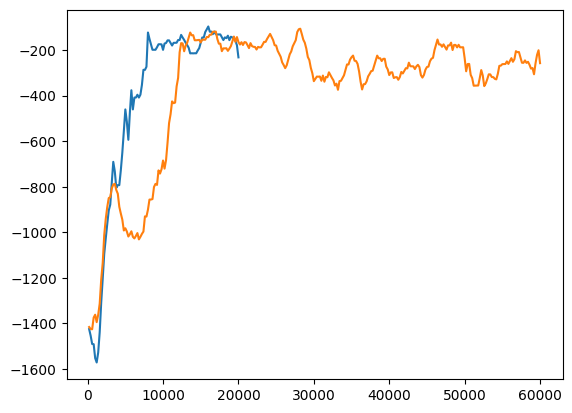

In [27]:
def plot_evaluated_return(all_ep_returns):
    avg_ret = []
    steps = []
    all_returns = []
    mod = len(avg_ret)%10
    all_ep_returns = all_ep_returns[:len(all_ep_returns)-mod]
    for a in all_ep_returns:
        all_returns.append(a[1])
    
    for r in range(len(all_ep_returns)):
        avg_ret.append(np.mean(all_returns[r:r+10]))
        steps.append(all_ep_returns[r][0])

    plt.plot(steps, avg_ret)
    plt.show

# plot_evaluated_return(all_ep_returns)
plot_evaluated_return(all_ep_returns2)
plot_evaluated_return(all_ep_returns3)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt

pendulum = gym.make("Pendulum-v1")
acrobot = gym.make('Acrobot-v1', render_mode="rgb_array")


EDMD KOOPMAN PLANNING + SAC

In [ ]:
class ReplayBuffer:
    def __init__(self, nO, nA, max_size):
        self.obs = np.zeros((max_size, nO))
        self.actions = np.zeros((max_size, nA))
        self.rewards = np.zeros((max_size))
        self.next_obs = np.zeros((max_size, nO))
        self.done = np.zeros(max_size)

        self.curr_size = 0
        self.max_size = max_size
        self.idx = 0

    def store(self, o, a, r, next_o, done):
        self.obs[self.idx] = o
        self.actions[self.idx] = a
        self.rewards[self.idx] = r
        self.next_obs[self.idx] = next_o
        self.done[self.idx] = done

        self.idx = (self.idx + 1) % self.max_size
        self.curr_size = min(self.curr_size + 1, self.max_size)

    def sample_batch(self, batch_size):
        batch_idxs = batch_idxs = np.random.randint(0, self.curr_size, size=batch_size)
        batch = {"obs": self.obs[batch_idxs],
                     "actions": self.actions[batch_idxs],
                     "rewards": self.rewards[batch_idxs],
                     "next_obs": self.next_obs[batch_idxs],
                     "done": self.done[batch_idxs]
        }
        return batch

def mlp(sizes, activation=nn.ReLU, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, action_limit):
        super().__init__()
        self.net = mlp([obs_dim] + hidden_sizes,
                       activation=nn.ReLU,
                       output_activation=nn.ReLU)
        
        self.mean_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)

        self.action_limit = action_limit
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX =  2

    def forward(self, obs):
        x = self.net(obs)
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mean, log_std.exp()

    def sample(self, obs):
        mean, std = self.forward(obs)
        normal = Normal(mean, std)

        z = normal.rsample()
        a = torch.tanh(z)
        action = self.action_limit * a

        log_prob = normal.log_prob(z) - torch.log(1 - a.pow(2) + 1e-7)
        log_prob = log_prob.sum(axis=-1, keepdim=True)

        mean_action = self.action_limit * torch.tanh(mean)
        return action, log_prob, mean_action


class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + hidden_sizes + [1],
                     activation=nn.ReLU,
                     output_activation=nn.Identity)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.q(x)
    


class KoopmanDynamics:
    def __init__(self, env, lifter_fn, state_dim, act_dim):
    
        if env.spec.id.startswith("Pendulum"):
            self.env_name = "Pendulum"
        elif env.spec.id.startswith("Acrobot"):
            self.env_name = "Acrobot"
        elif env.spec.id.startswith("CartPole"):
            self.env_name = "CartPole"

        self.lifter_fn = lifter_fn
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.K = None
        self.B = None


    def lift(self, s):

        if self.env_name == "Pendulum":
            cs, sn, w = s
            return [cs, sn, w, cs*w, sn*w, cs**2, sn**2, w**2]
        
        elif self.env_name == "Acrobot":
            cs1, sn1, cs2, sn2, w1, w2 = s
            return [cs1, sn1, cs2, sn2, w1, w2,
                    cs1*w1, cs1*w2, cs1*sn1, cs1*sn2, cs1*cs2, cs1*cs1,
                    sn1*w1, sn1*w2, sn1*sn1, sn1*sn2, sn1*cs2, sn1*cs1,
                    cs2*w1, cs2*w2, cs2*sn1, cs2*sn2, cs2*cs2, cs2*cs1,
                    sn2*w1, sn2*w2, sn2*sn2, sn2*sn2, sn2*cs2, sn2*cs1,
                    w1*w1, w1*w2, w1*sn1, w1*sn2, w1*cs2, w1*cs1,
                    w2*w1, w2*w2, w2*sn1, w2*sn2, w2*cs2, w2*cs1]

        elif self.env_name == "CartPole":
            x, dx, th, dth = s
            return [
                x, dx, th, dth,
                np.sin(th), np.cos(th),
                x*th, dx*dth,
                th**2, dth**2
            ]


    def fit(self, states, actions, next_states):
        """
        Fit Koopman operator from a batch of transitions.
        states:      (N, state_dim)
        actions:     (N, act_dim)
        next_states: (N, state_dim)
        """
        N = states.shape[0]

        # ---- Lift states ---- #
        Z = np.array([self.lift(s) for s in states])         # (N, lift_dim)
        Zp = np.array([self.lift(sp) for sp in next_states]) # (N, lift_dim)
        U = actions                                          # (N, act_dim)

        # Transpose to match EDMD math:
        # Z:  (lift_dim, N)
        # Zp: (lift_dim, N)
        # U:  (act_dim, N)
        Z  = Z.T
        Zp = Zp.T
        U  = U.T

        lift_dim = Z.shape[0]

        # ---- Build regression matrix ---- #
        XU = np.vstack([Z, U])   # shape (lift_dim + act_dim, N)

        # ---- Solve [K B] = Zp * pinv([Z;U]) ---- #
        A = Zp @ np.linalg.pinv(XU)

        self.K = A[:, :lift_dim]
        self.B = A[:, lift_dim : lift_dim + self.act_dim]

        return self.K, self.B

    def predict_lifted(self, s, a):
        """Predict z_{t+1} in lifted space."""
        z = self.lift(s)
        return self.K @ z + self.B @ a

    def decode(self, z):
        """Decode z back to the original state (assumes first state_dim entries)."""
        return z[:self.state_dim]

    def predict_state(self, s, a):
        """Predict next original state."""
        z_next = self.predict_lifted(s, a)
        return self.decode(z_next)
    
    
    

class SACAgent:
    def __init__(self, obs_dim, act_dim, action_limit,
                 gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=3e-4, critic_lr=3e-4,
                 hidden_sizes=[256, 256]):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_limit = action_limit
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha   # entropy coefficient

        # Actor
        self.actor = GaussianPolicy(obs_dim, act_dim, hidden_sizes, action_limit).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critics
        self.q1 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q1_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=critic_lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=critic_lr)

    def select_action(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if deterministic:
                _, _, action = self.actor.sample(obs)
            else:
                action, _, _ = self.actor.sample(obs)
        return action.cpu().numpy()[0]

    def update(self, batch):
        obs = torch.as_tensor(batch['obs'], dtype=torch.float32, device=self.device)
        acts = torch.as_tensor(batch['actions'], dtype=torch.float32, device=self.device)
        rews = torch.as_tensor(batch['rewards'], dtype=torch.float32, device=self.device).unsqueeze(-1)
        next_obs = torch.as_tensor(batch['next_obs'], dtype=torch.float32, device=self.device)
        done = torch.as_tensor(batch['done'], dtype=torch.float32, device=self.device).unsqueeze(-1)

        # -------- Target Q -------- #
        with torch.no_grad():
            next_action, next_log_prob, _ = self.actor.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_target = torch.min(q1_next, q2_next) - self.alpha * next_log_prob
            target_value = rews + self.gamma * (1 - done) * q_target

        # -------- Update Q1 -------- #
        q1 = self.q1(obs, acts)
        q1_loss = F.mse_loss(q1, target_value)
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        # -------- Update Q2 -------- #
        q2 = self.q2(obs, acts)
        q2_loss = F.mse_loss(q2, target_value)
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        # -------- Update Actor -------- #
        new_actions, log_prob, _ = self.actor.sample(obs)
        q1_new = self.q1(obs, new_actions)
        q2_new = self.q2(obs, new_actions)
        q_new = torch.min(q1_new, q2_new)

        actor_loss = (self.alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # -------- Soft update targets -------- #
        with torch.no_grad():
            for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)
            for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)



def koopman_reward(koopman_model, s, a):
    """
    Approximate immediate reward r(s,a) using env-specific formula.
    Currently implemented for Pendulum.
    """
    if koopman_model.env_name == "Pendulum":
        cs, sn, w = s
        theta = np.arctan2(sn, cs)
        u = float(a[0])
        cost = theta**2 + 0.1 * (w**2) + 0.001 * (u**2)
        return -cost
    else:
        # Fallback: no reward model → 0
        # (You can add Acrobot/CartPole versions later)
        return 0.0


def plan_action_with_model(state, agent, koopman_model, action_limit,
                           H=5, N=64, iters=3, gamma=0.99, beta=0.7):
    """
    Koopman-MPC style planner:
    - state: np array (obs_dim,)
    - agent: SACAgent
    - koopman_model: KoopmanDynamics (with K,B already fitted)
    Returns: np array action (act_dim,)
    """

    # If Koopman not ready, just use SAC
    if koopman_model.K is None or koopman_model.B is None:
        return agent.select_action(state, deterministic=False)

    device = agent.device
    obs_dim = agent.obs_dim
    act_dim = agent.act_dim

    # Initial lifted state
    z0 = np.asarray(koopman_model.lift(state), dtype=np.float32)
    lift_dim = z0.shape[0]

    # Get actor's mean action as prior (PyTorch → numpy)
    with torch.no_grad():
        s0_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        mean_action, _, _ = agent.actor.sample(s0_t)
        mean_action = mean_action.squeeze(0).cpu().numpy()  # (act_dim,)

    # Init mean & std of action sequence: (H, act_dim)
    seq_mean = np.tile(mean_action[None, :], (H, 1))              # (H, act_dim)
    seq_std  = 0.5 * action_limit * np.ones_like(seq_mean)        # (H, act_dim)

    for _ in range(iters):
        # Sample N action sequences: (N, H, act_dim)
        eps = np.random.randn(N, H, act_dim).astype(np.float32)
        actions = seq_mean[None, :, :] + seq_std[None, :, :] * eps
        actions = np.clip(actions, -action_limit, action_limit)

        # Roll out each sequence using Koopman
        returns = np.zeros((N,), dtype=np.float32)

        for i in range(N):
            z = z0.copy()
            s = state.copy()
            G = 0.0
            discount = 1.0

            for t in range(H):
                a_t = actions[i, t, :]  # (act_dim,)
                r_t = koopman_reward(koopman_model, s, a_t)
                G += discount * r_t

                # Koopman one-step in z-space
                z = koopman_model.K @ z + koopman_model.B @ a_t
                # Decode to state (first state_dim components)
                s = koopman_model.decode(z)

                discount *= gamma

            # Bootstrap with SAC critic at s_H
            with torch.no_grad():
                s_t = torch.as_tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
                a_boot, _, _ = agent.actor.sample(s_t)
                q1_H = agent.q1(s_t, a_boot)
                q2_H = agent.q2(s_t, a_boot)
                q_H = torch.min(q1_H, q2_H).item()
            G += discount * q_H

            returns[i] = G

        # Softmax weights over sequences (CEM-like)
        returns_max = np.max(returns)
        scores = returns - returns_max
        weights = np.exp(beta * scores)
        weights /= np.sum(weights) + 1e-8    # (N,)

        # Update mean and std per time-step
        # actions: (N, H, act_dim), weights: (N,)
        w = weights[:, None, None]           # (N, 1, 1)
        new_mean = np.sum(w * actions, axis=0)                 # (H, act_dim)
        diff = actions - new_mean[None, :, :]
        new_std = np.sqrt(np.sum(w * diff**2, axis=0) + 1e-6)  # (H, act_dim)

        seq_mean = new_mean
        seq_std  = new_std

    # Use mean action at time t=0
    a0 = seq_mean[0]
    return a0.astype(np.float32)


def train_sac_with_planning(env):
    # env = gym.make("Pendulum-v1")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    action_limit = float(env.action_space.high[0])

    # Agents + replay
    agent = SACAgent(obs_dim, act_dim, action_limit)
    replay_buffer = ReplayBuffer(obs_dim, act_dim, max_size=200000)

    # Koopman model
    koopman_model = KoopmanDynamics(env, lifter_fn=None,
                                    state_dim=obs_dim, act_dim=act_dim)

    # ==== Hyperparameters ====
    MAX_EPISODES = 100        # <---- STOP after this many episodes
    max_ep_len   = 200        # max length of each episode
    start_steps  = 1000       # random exploration steps
    update_after = 1000       # start updating SAC after this many steps total
    update_every = 50         # update SAC every X steps
    batch_size   = 256

    koopman_train_every = 5   # <---- fit Koopman every 5 episodes
    koopman_max_samples = 5000

    total_steps = 0
    all_steps = 0
    all_ep_returns = []

    # ========== EPISODE LOOP (MAIN CHANGE) ==========
    for episode in range(1, MAX_EPISODES + 1):

        state, _ = env.reset()
        ep_return = 0.0
        ep_len = 0

        for t in range(max_ep_len):
            # ---- ACTION SELECTION ----
            if total_steps < start_steps or koopman_model.K is None:
                if total_steps < start_steps:
                    action = env.action_space.sample()
                else:
                    action = agent.select_action(state, deterministic=False)
            else:
                action = plan_action_with_model(
                    state, agent, koopman_model, action_limit,
                    H=5, N=64, iters=3, gamma=agent.gamma, beta=0.7
                )

            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # ---- Store in replay ----
            replay_buffer.store(state, action, reward, next_state, float(done))

            state = next_state
            ep_return += reward
            ep_len += 1
            total_steps += 1

            # ---- SAC updates ----
            if total_steps >= update_after and total_steps % update_every == 0:
                for _ in range(update_every):
                    batch = replay_buffer.sample_batch(batch_size)
                    agent.update(batch)

            if done:
                break

        # ===== END EPISODE =====
        print(f"Episode {episode} | Return {ep_return:.2f} | Length {ep_len}")
        all_steps += ep_len
        all_ep_returns.append((all_steps, ep_return))

        # ===== FIT KOOPMAN EVERY X EPISODES =====
        if episode % koopman_train_every == 0 and replay_buffer.curr_size > 1000:
            N = min(replay_buffer.curr_size, koopman_max_samples)
            idxs = np.random.choice(replay_buffer.curr_size, size=N, replace=False)
            states = replay_buffer.obs[idxs]
            actions = replay_buffer.actions[idxs]
            next_states = replay_buffer.next_obs[idxs]
            K, B = koopman_model.fit(states, actions, next_states)
            print(f"[Episode {episode}] Fitted Koopman: K {K.shape}, B {B.shape}")

    env.close()
    print("Training complete (episode-based).")

    # Save trained SAC policy
    torch.save(agent.actor.state_dict(), "actor_final_plan_Koopman_H-Step.pt")
    torch.save(agent.q1.state_dict(),   "q1_final_plan_q1_Koopman_H-Step.pt")
    torch.save(agent.q2.state_dict(),   "q2_final_plan_q2_Koopman_H-Step.pt")
    print("Saved SAC weights!")

    return agent, koopman_model, all_steps, all_ep_returns


def run_agent(agent, env_name="Pendulum-v1", episodes=3, max_steps=200, deterministic=True):
    env = gym.make(env_name, render_mode="human")

    for ep in range(episodes):
        state, _ = env.reset()
        ep_return = 0

        print(f"\n=== Running Episode {ep+1}/{episodes} ===")

        for step in range(max_steps):
            action = agent.select_action(state, deterministic=deterministic)
            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state

            ep_return += reward
            if terminated or truncated:
                break

        print(f"Episode {ep+1} Return = {ep_return:.2f}")

    env.close()
    print("\nDone displaying agent!")


if __name__ == "__main__":
    agent, koopman_model, all_steps3, all_ep_returns3 = train_sac_with_planning(pendulum)
    run_agent(agent, env_name="Pendulum-v1", episodes=3, deterministic=True)



Episode 1 | Return -1336.11 | Length 200
Episode 2 | Return -1289.14 | Length 200
Episode 3 | Return -1548.31 | Length 200
Episode 4 | Return -1274.56 | Length 200
Episode 5 | Return -811.53 | Length 200
Episode 6 | Return -1269.61 | Length 200
Episode 7 | Return -1525.92 | Length 200
Episode 8 | Return -1810.88 | Length 200
Episode 9 | Return -1504.22 | Length 200
Episode 10 | Return -1788.92 | Length 200
[Episode 10] Fitted Koopman: K (8, 8), B (8, 1)
Episode 11 | Return -1425.04 | Length 200
Episode 12 | Return -1299.23 | Length 200
Episode 13 | Return -1035.53 | Length 200
Episode 14 | Return -1147.83 | Length 200
Episode 15 | Return -1139.15 | Length 200
[Episode 15] Fitted Koopman: K (8, 8), B (8, 1)
Episode 16 | Return -945.40 | Length 200
Episode 17 | Return -1039.69 | Length 200
Episode 18 | Return -749.77 | Length 200
Episode 19 | Return -778.89 | Length 200
Episode 20 | Return -564.70 | Length 200
[Episode 20] Fitted Koopman: K (8, 8), B (8, 1)
Episode 21 | Return -720.19 | 

In [5]:
run_agent(agent, env_name="Pendulum-v1", episodes=3, deterministic=True)


=== Running Episode 1/3 ===
Episode 1 Return = -119.86

=== Running Episode 2/3 ===
Episode 2 Return = -122.04

=== Running Episode 3/3 ===
Episode 3 Return = -235.69

Done displaying agent!


<class 'list'>
2
Saved ep_all_returns to .\returns\ep_returns_SAC.npy with shape (100, 2)


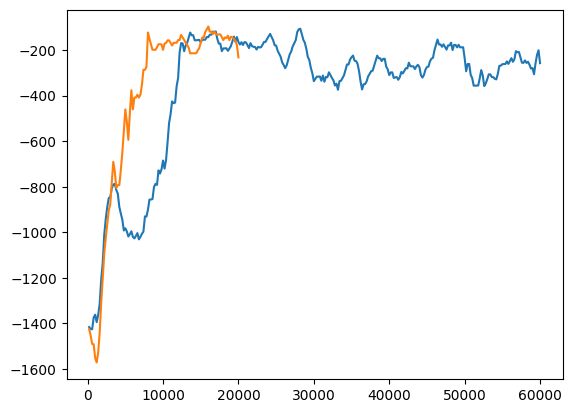

In [26]:
plot_evaluated_return(all_ep_returns3)
plot_evaluated_return(all_ep_returns2)
print(type(all_ep_returns3))
print(len(all_ep_returns3[0]))


def save_ep_returns(ep_all_returns, filename):
    """Save list of 2D coordinates to a .npy file."""
    arr = np.array(ep_all_returns, dtype=np.float32)
    np.save(filename, arr)
    print(f"Saved ep_all_returns to {filename} with shape {arr.shape}")

def load_ep_returns(filename):
    """Load the saved list of 2D coordinates."""
    arr = np.load(filename)
    ep_all_returns = arr.tolist()
    print(f"Loaded ep_all_returns from {filename} with shape {arr.shape}")
    return ep_all_returns


save_ep_returns(all_ep_returns2, r".\returns\ep_returns_SAC.npy")